<a href="https://colab.research.google.com/github/Aniruddha008/Track/blob/master/track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Aniruddha008/Track

Cloning into 'Track'...
remote: Enumerating objects: 14956, done.
remote: Total 14956 (delta 0), reused 0 (delta 0), pack-reused 14956
Receiving objects: 100% (14956/14956), 187.98 MiB | 32.99 MiB/s, done.
Checking out files: 100% (14953/14953), done.


In [ ]:
!ls Track

driving_log.csv  IMG


In [ ]:
!pip install imgaug

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout,Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam, SGD
import ntpath
from imgaug import augmenters as iaa

In [ ]:
datadir = 'Track'
columns  = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head(5)

,center,left,right,steering,throttle,reverse,speed
0,E:\sdc\simulator\IMG\center_2021_08_20_00_39_41_226.jpg,E:\sdc\simulator\IMG\left_2021_08_20_00_39_41_226.jpg,E:\sdc\simulator\IMG\right_2021_08_20_00_39_41_226.jpg,0.0,0.0,0.0,0.000078
1,E:\sdc\simulator\IMG\center_2021_08_20_00_39_41_327.jpg,E:\sdc\simulator\IMG\left_2021_08_20_00_39_41_327.jpg,E:\sdc\simulator\IMG\right_2021_08_20_00_39_41_327.jpg,0.0,0.0,0.0,0.000078
2,E:\sdc\simulator\IMG\center_2021_08_20_00_39_41_430.jpg,E:\sdc\simulator\IMG\left_2021_08_20_00_39_41_430.jpg,E:\sdc\simulator\IMG\right_2021_08_20_00_39_41_430.jpg,0.0,0.0,0.0,0.000078
3,E:\sdc\simulator\IMG\center_2021_08_20_00_39_41_534.jpg,E:\sdc\simulator\IMG\left_2021_08_20_00_39_41_534.jpg,E:\sdc\simulator\IMG\right_2021_08_20_00_39_41_534.jpg,0.0,0.0,0.0,0.000080
4,E:\sdc\simulator\IMG\center_2021_08_20_00_39_41_635.jpg,E:\sdc\simulator\IMG\left_2021_08_20_00_39_41_635.jpg,E:\sdc\simulator\IMG\right_2021_08_20_00_39_41_635.jpg,0.0,0.0,0.0,0.000080


In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [ ]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head(5)

,center,left,right,steering,throttle,reverse,speed
0,center_2021_08_20_00_39_41_226.jpg,left_2021_08_20_00_39_41_226.jpg,right_2021_08_20_00_39_41_226.jpg,0.0,0.0,0.0,0.000078
1,center_2021_08_20_00_39_41_327.jpg,left_2021_08_20_00_39_41_327.jpg,right_2021_08_20_00_39_41_327.jpg,0.0,0.0,0.0,0.000078
2,center_2021_08_20_00_39_41_430.jpg,left_2021_08_20_00_39_41_430.jpg,right_2021_08_20_00_39_41_430.jpg,0.0,0.0,0.0,0.000078
3,center_2021_08_20_00_39_41_534.jpg,left_2021_08_20_00_39_41_534.jpg,right_2021_08_20_00_39_41_534.jpg,0.0,0.0,0.0,0.000080
4,center_2021_08_20_00_39_41_635.jpg,left_2021_08_20_00_39_41_635.jpg,right_2021_08_20_00_39_41_635.jpg,0.0,0.0,0.0,0.000080


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


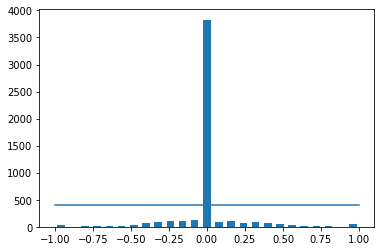

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[: -1] + bins[1:]) * 0.5
print(bins)

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data:  4984
removed:  3428
remaining:  1556


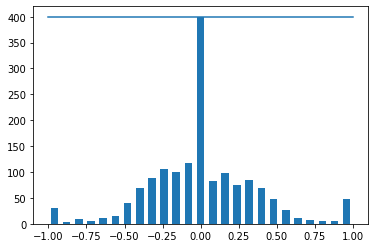

In [ ]:
print('total data: ', len(data))
remove_list = []

for j in range(num_bins):

  list_ = []
  for i in range(len(data['steering'])):

    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:

      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin: ]
  remove_list.extend(list_)

print('removed: ',len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))  

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):

  image_path = []
  steering = []
  for i in range(len(data)):

    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)

  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2021_08_20_00_39_43_165.jpg
left          left_2021_08_20_00_39_43_165.jpg
right        right_2021_08_20_00_39_43_165.jpg
steering                                     0
throttle                                     1
reverse                                      0
speed                                  2.31746
Name: 19, dtype: object


In [ ]:
X_train, X_valid, y_train, y_valid =train_test_split(image_paths, steerings, test_size = 0.2, random_state = 42)

In [ ]:
print(f"X_train samples: {len(X_train)}, X_valid samples: {len(X_valid)}")

X_train samples: 1244, X_valid samples: 312


Text(0.5, 1.0, 'Valid set')

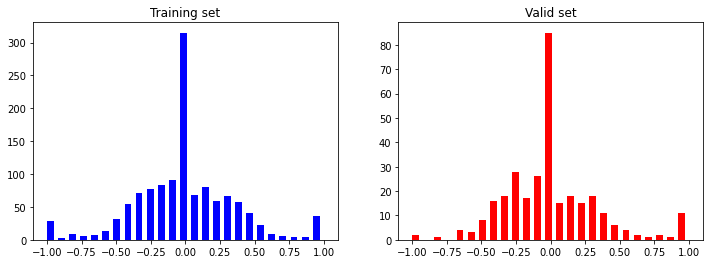

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')

axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Valid set')

In [ ]:
def zoom(image):

  z = iaa.Affine(scale = (1, 1.3))
  image = z.augment_image(image)
  return image

Text(0.5, 1.0, 'zoomed Image')

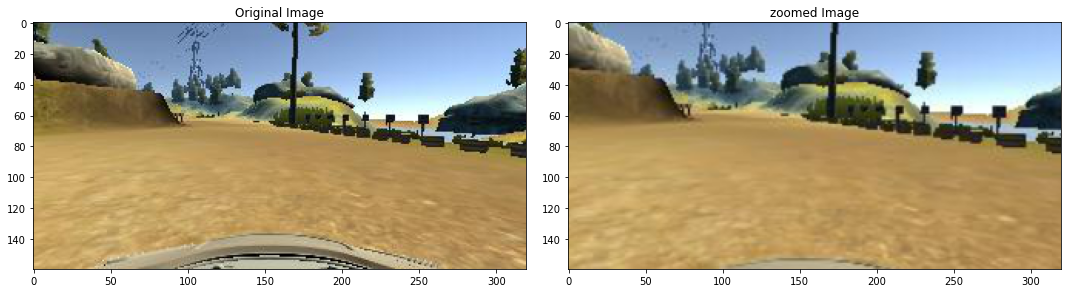

In [ ]:
t_img = image_paths[700]
original_image = mpimg.imread(t_img)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed Image')

In [ ]:
def pan(image):

  p = iaa.Affine(translate_percent={"x" : (-0.1,0.1), "y":(-0.1, 0.1)})
  image = p.augment_image(image)
  return image

Text(0.5, 1.0, 'panned Image')

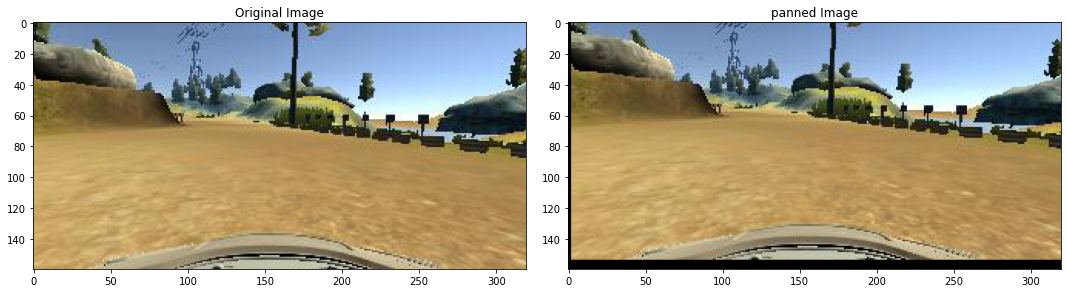

In [ ]:
t_img = image_paths[700]
original_image = mpimg.imread(t_img)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('panned Image')

In [ ]:
def img_random_brightness(image):

  b = iaa.Multiply((0.2, 1.2))
  image = b.augment_image(image)
  return image


Text(0.5, 1.0, 'Random Brightness of Image')

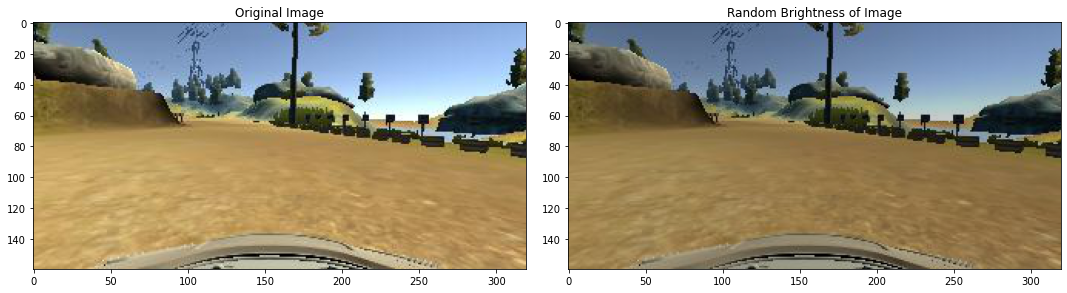

In [ ]:
t_img = image_paths[700]
original_image = mpimg.imread(t_img)
random_bright_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(random_bright_image)
axs[1].set_title('Random Brightness of Image')


In [ ]:
def random_flip(image, steering_angle):

  image = cv2.flip(image, 1)
  steering_angle = -steering_angle

  return image, steering_angle



Text(0.5, 1.0, 'Random flipped of Image')

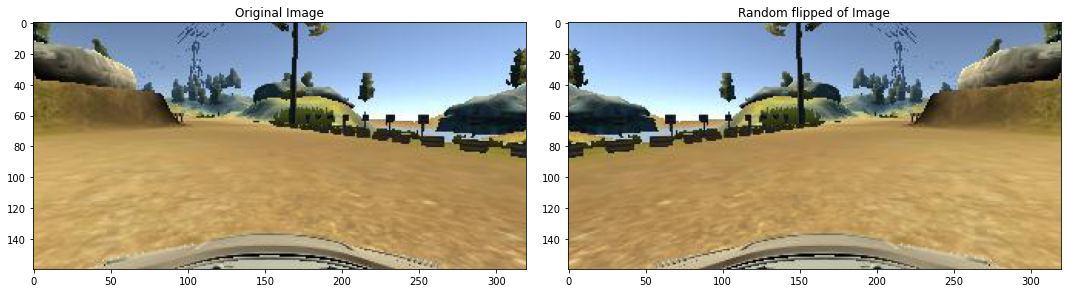

In [ ]:
t_img = image_paths[700]
original_image = mpimg.imread(t_img)
steering_angle = steerings[700]
random_flip_image, flipped_steering_angle = random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(random_flip_image)
axs[1].set_title('Random flipped of Image')


In [ ]:
def random_augment(image, steering_angle):

  image = mpimg.imread(image)

  if np.random.rand() < 0.5:

    image = pan(image)

  if np.random.rand() < 0.5:

    image = zoom(image)

  if np.random.rand() < 0.5:

    image, steering_angle = random_flip(image, steering_angle)

  if np.random.rand() < 0.5:

    image = img_random_brightness(image)

  return image, steering_angle

In [ ]:
def img_preprocess(img):

  #img = mpimg.imread(img)
  img = img[60: 135,:, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img / 255
  return img

In [ ]:
"""
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Originial image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')
"""

"\nimage = image_paths[100]\noriginal_image = mpimg.imread(image)\npreprocessed_image = img_preprocess(image)\n\nfig, axs = plt.subplots(1, 2, figsize = (15, 10))\nfig.tight_layout()\naxs[0].imshow(original_image)\naxs[0].set_title('Originial image')\naxs[1].imshow(preprocessed_image)\naxs[1].set_title('Preprocessed image')\n"

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))


In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

In [ ]:
#X_train = np.array(list(map(img_preprocess, X_train)))
#X_valid = np.array(list(map(img_preprocess, X_valid)))

In [ ]:
#plt.imshow(X_train[120])
#plt.axis('off')
#print(X_train.shape)

In [ ]:
def nvidia_model():

    model = Sequential()
     
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), 
                     input_shape=(66,200,3),activation='elu'))
     
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Dropout(0.5))
     
     
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
     
     
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))
     
     
    optimizer= Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
     
    return model

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [ ]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=30,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/30
300/300 [==============================] - 215s 612ms/step - loss: 0.1756 - val_loss: 0.1078
Epoch 2/30
300/300 [==============================] - 181s 606ms/step - loss: 0.1238 - val_loss: 0.0961
Epoch 3/30
300/300 [==============================] - 178s 596ms/step - loss: 0.1173 - val_loss: 0.0880
Epoch 4/30
300/300 [==============================] - 175s 586ms/step - loss: 0.1126 - val_loss: 0.0774
Epoch 5/30
300/300 [==============================] - 175s 586ms/step - loss: 0.1044 - val_loss: 0.0664
Epoch 6/30
300/300 [==============================] - 174s 582ms/step - loss: 0.1000 - val_loss: 0.0737
Epoch 7/30
300/300 [==============================] - 174s 582ms/step - loss: 0.0973 - val_loss: 0.0698
Epoch 8/30
300/300 [==============================] - 174s 583ms/step - loss: 0.0921 - val_loss: 0.0538
Epoch 9/30
300/300 [==============================] - 174s 582ms/step - loss: 0.0889 - val_loss: 0.0461
Epoch 10/30
300/300 [==============================] - 174s 582m

Text(0.5, 0, 'Epochs')

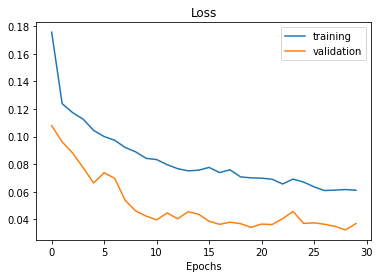

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epochs')

In [ ]:
model.save('model_gen_1_30e.h5')

In [ ]:
from google.colab import files

In [ ]:
def nvidia_model2():

    model = Sequential()
     
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), 
                     input_shape=(66,200,3),activation='elu'))
     
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    #model.add(Dropout(0.5))
     
     
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    #model.add(Dropout(0.5))
     
     
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))
     
     
    optimizer= Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
     
    return model

In [ ]:
model2 = nvidia_model2()
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [ ]:
history2 = model2.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=30,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/30
300/300 [==============================] - 174s 579ms/step - loss: 0.1433 - val_loss: 0.0897
Epoch 2/30
300/300 [==============================] - 173s 578ms/step - loss: 0.1097 - val_loss: 0.0541
Epoch 3/30
300/300 [==============================] - 173s 580ms/step - loss: 0.0901 - val_loss: 0.0486
Epoch 4/30
300/300 [==============================] - 175s 585ms/step - loss: 0.0761 - val_loss: 0.0489
Epoch 5/30
300/300 [==============================] - 173s 579ms/step - loss: 0.0689 - val_loss: 0.0447
Epoch 6/30
300/300 [==============================] - 173s 579ms/step - loss: 0.0663 - val_loss: 0.0421
Epoch 7/30
300/300 [==============================] - 173s 580ms/step - loss: 0.0642 - val_loss: 0.0384
Epoch 8/30
300/300 [==============================] - 175s 585ms/step - loss: 0.0609 - val_loss: 0.0374
Epoch 9/30
300/300 [==============================] - 172s 576ms/step - loss: 0.0596 - val_loss: 0.0500
Epoch 10/30
300/300 [==============================] - 172s 575m

Text(0.5, 0, 'Epochs')

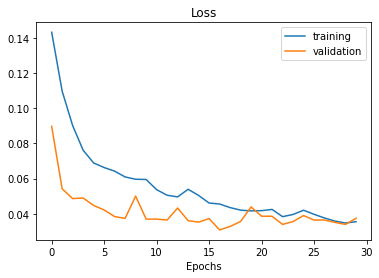

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epochs')

In [ ]:
model2.save('model_gen_2_30e.h5')

In [ ]:
from google.colab import files

In [ ]:
files.download('model_gen_2_30e.h5')
files.download('model_gen_1_30e.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>